# Error Projections

In [1]:
#  Plotly Visualization
import plotly.graph_objects as go
import plotly.express       as px
import plotly.subplots      as sp

# OpenCV
import cv2

# Pandas 
import pandas as pd

import logging
import math

from tqdm.notebook import tqdm

#  Numpy
import numpy as np

import scipy.interpolate

from pyproj import CRS, Transformer

# Terminus APIs
from tmns.core.types import GCP
from tmns.dem.gtiff import DEM_File as DEM
from tmns.dem.fixed import Fixed_DEM as Flat
from tmns.proj.RPC00B import RPC00B, RPC_Type, Solve_Method
from tmns.proj.SENSRB import ( SENSRB, Term as SENSRB_Term )

In [2]:
logging.basicConfig( level = logging.INFO )
logger = logging.getLogger('notebook')

In [3]:
srtm_path = 'SRTM_GL1.tif'
dem = DEM( srtm_path )

In [4]:
flat_dem = Flat( elevation_meters = 1612 )

In [5]:
crd_xform = Transformer.from_crs( 4326, 32613, always_xy = True )
inv_xform = Transformer.from_crs( 32613, 4326, always_xy = True )

In [6]:
img_path = 'ARUDEN000040045.2.tif'

In [7]:
img_bands = cv2.cvtColor( cv2.imread( img_path, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
print(img_bands.shape)

(2964, 2829, 3)


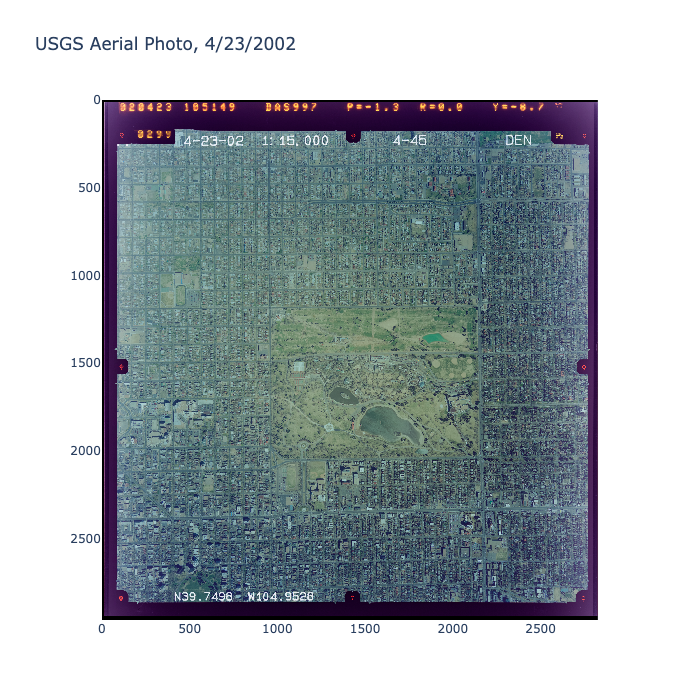

In [8]:
fig1 = go.Figure()
fig1.add_trace( go.Image( z = img_bands ) )
fig1.update_layout( title = 'USGS Aerial Photo, 4/23/2002',
                    height = 700 )
fig1.show( renderer = 'png' )

## Setup Ground Control Points

In [9]:
gcp_df = pd.read_csv( 'GCPs.csv' )
mean_elevation = gcp_df['Elevation'].mean()
gcp_df['Elevation'] = mean_elevation
display( gcp_df.head(5) )
display( f'Total of {gcp_df.shape[0]} GCPs loaded' )

,Name,PX,PY,Latitude,Longitude,Elevation
0,Thatcher Fountain,1149,1971,39.744825,-104.956856,1608.813953
1,31st and Gilpin,486,677,39.760815,-104.967139,1608.813953
2,29th and Gilpin,478,876,39.758338,-104.967319,1608.813953
3,26th and Williams,555,1179,39.754582,-104.966093,1608.813953
4,21st and Franklin,398,1696,39.748303,-104.968554,1608.813953


'Total of 86 GCPs loaded'

In [10]:
lla_gcp_list = []
utm_gcp_list = []
counter = 0
for gcp in gcp_df.itertuples():

    utm = crd_xform.transform( gcp.Longitude, gcp.Latitude )

    lla_gcp_list.append( GCP( id = counter,
                              pixel = np.array( [ gcp.PX, gcp.PY ], dtype = np.float64 ),
                              coordinate = np.array( [ gcp.Longitude, gcp.Latitude, gcp.Elevation ], dtype = np.float64 ) ) )
    
    utm_gcp_list.append( GCP( id = counter,
                              pixel = np.array( [ gcp.PX, gcp.PY ], dtype = np.float64 ),
                              coordinate = np.array( [ utm[0], utm[1], gcp.Elevation ], dtype = np.float64 ) ) )
    counter += 1

In [11]:
print( f'Loaded {len(lla_gcp_list)} Ground Control Points' )

Loaded 86 Ground Control Points


![GCP List](./docs/gcp_list.png)

In [12]:
image_size = img_bands.shape[0:2]
print( f'Image Size: {image_size}' )

Image Size: (2964, 2829)


## Estimating Projection Errors

In [13]:
class ProjectionErrors:
    
    def __init__( self ):
        self.points = []

        self.p2w = False
        self.pix_deltas = []
        self.utm_deltas = []
        
        self.mean_pix_error = []
        self.mean_utm_error = []
        
        self.rms_pix_error = []
        self.rms_utm_error = []
        
        self.max_pix_error = 0
        self.max_utm_error = 0
        
        self.pix_sum = 0
        self.utm_sum = 0

        self.pix_grid_vals = None
        self.utm_grid_vals = None

In [14]:
def compute_errors( model, dem, gcp_list, p2w = True ):

    errors = ProjectionErrors()

    #  Iterate over GCPs
    for gcp in gcp_list:

        #  Convert the Geographic coordinate to UTM
        gcp_utm = crd_xform.transform( *gcp.coordinate[0:2] )
    
        #  World coordinate
        lla = model.pixel_to_world( gcp.pixel,
                                    dem_model = dem )

        #  UTM Conversions
        magUtmDelta = 0
        if p2w == True:
            errors.p2w = True
            utm = np.array( crd_xform.transform( *lla )[0:2] )
            delta = utm - gcp_utm
            magUtmDelta = math.sqrt( np.dot( delta, delta ) )
            errors.utm_sum += magUtmDelta
            errors.utm_deltas.append( magUtmDelta )

        #  Coordinate to UTM Conversions
        pix = model.world_to_pixel( gcp.coordinate )[0:2].reshape(2)
        delta = pix - gcp.pixel
        magPixDelta = math.sqrt( np.dot( delta, delta ) )
        errors.pix_sum += magPixDelta
        errors.pix_deltas.append( magPixDelta )

        errors.points.append( gcp.pixel )
    

        if magPixDelta > errors.max_pix_error:
            errors.max_pix_error = magPixDelta
        if magUtmDelta > errors.max_utm_error:
            errors.max_utm_error = magUtmDelta

    if errors.p2w:
        errors.mean_utm_error = errors.utm_sum / len(gcp_list)
        errors.rms_utm_error  = math.sqrt( errors.mean_utm_error )

    errors.mean_pix_error = errors.pix_sum / len(gcp_list)
    errors.rms_pix_error  = math.sqrt( errors.mean_pix_error )

    numPixels = 100

    if errors.p2w:
        print( f'UTM RMS Error: {errors.rms_utm_error:.02f} meters\nMean Error: {errors.mean_utm_error:.02f} meters' )
    print( f'PIX RMS Error: {errors.rms_pix_error:.02f} pixels\nMean Error: {errors.mean_pix_error:.02f} pixels' )

    grid_x, grid_y = np.mgrid[ 0:int(image_size[0]):numPixels, 0:int(image_size[1]):numPixels ]

    errors.pix_grid_vals = scipy.interpolate.griddata( errors.points, errors.pix_deltas, (grid_x, grid_y), method='linear' )

    if errors.p2w:
        errors.utm_grid_vals = scipy.interpolate.griddata( errors.points, errors.utm_deltas, (grid_x, grid_y), method='linear' )

    return errors

## 4 Corner Estimation

In [15]:
tl_gcp = None
tl_gcp_dist = 1e6

tr_gcp = None
tr_gcp_dist = 1e6

bl_gcp = None
bl_gcp_dist = 1e6

br_gcp = None
br_gcp_dist = 1e6

for gcp in utm_gcp_list:

    if tl_gcp == None:
        tl_gcp = gcp
        delta = tl_gcp.pixel - np.array( [0.0, 0.0] )
        tl_gcp_dist = math.sqrt( np.dot( delta, delta ) )

    delta = gcp.pixel - np.array( [0.0, 0.0] )
    dist = math.sqrt( np.dot( delta, delta ) )
    if dist < tl_gcp_dist:
        tl_gcp = gcp
        tl_gcp_dist = dist

    if tr_gcp == None:
        tr_gcp = gcp
        delta = tr_gcp.pixel - np.array( [img_bands.shape[0]-1, 0.0] )
        tr_gcp_dist = math.sqrt( np.dot( delta, delta ) )

    delta = gcp.pixel - np.array( [img_bands.shape[0]-1, 0.0] )
    dist = math.sqrt( np.dot( delta, delta ) )
    if dist < tr_gcp_dist:
        tr_gcp = gcp
        tr_gcp_dist = dist
        
    if bl_gcp == None:
        bl_gcp = gcp
        delta = bl_gcp.pixel - np.array( [0.0, img_bands.shape[1]-1] )
        bl_gcp_dist = math.sqrt( np.dot( delta, delta ) )

    delta = gcp.pixel - np.array( [0.0, img_bands.shape[1]-1] )
    dist = math.sqrt( np.dot( delta, delta ) )
    if dist < bl_gcp_dist:
        bl_gcp = gcp
        bl_gcp_dist = dist
        
    if tr_gcp == None:
        br_gcp = gcp
        delta = br_gcp.pixel - np.array( [img_bands.shape[0]-1, img_bands.shape[1]-1] )
        br_gcp_dist = math.sqrt( np.dot( delta, delta ) )

    delta = gcp.pixel - np.array( [img_bands.shape[0]-1, img_bands.shape[1]-1] )
    dist = math.sqrt( np.dot( delta, delta ) )
    if dist < br_gcp_dist:
        br_gcp = gcp
        br_gcp_dist = dist

print( tl_gcp )
print( tr_gcp )
print( bl_gcp )
print( br_gcp )

tl_utm = tl_gcp.coordinate[0:2]
tl_pix = tl_gcp.pixel

tr_utm = tr_gcp.coordinate[0:2]
tr_pix = tr_gcp.pixel

bl_utm = bl_gcp.coordinate[0:2]
bl_pix = bl_gcp.pixel

br_utm = br_gcp.coordinate[0:2]
br_pix = br_gcp.pixel

GCP: id: 17, pixel: [168.000000 373.000000], coordinate: [5.023821e+05 4.401628e+06 1.608814e+03]
GCP: id: 11, pixel: [2666.000000  267.000000], coordinate: [5.058269e+05 4.401760e+06 1.608814e+03]
GCP: id: 23, pixel: [ 112.000000 2663.000000], coordinate: [5.023170e+05 4.398547e+06 1.608814e+03]
GCP: id: 8, pixel: [2755.000000 2774.000000], coordinate: [5.058725e+05 4.398306e+06 1.608814e+03]


In [16]:
def pix_to_utm( pixel, image_size ):
    #  Get the interpolation factors
    tx = pixel[0] / image_size[0]
    ty = pixel[1] / image_size[1]

    # Solve the UTM Coordinate
    utm_p1 = tl_utm[0:2] * (1-tx) + tr_utm[0:2] * tx
    utm_p2 = bl_utm[0:2] * (1-tx) + br_utm[0:2] * tx
    utm_pt = utm_p1 * (1-ty) + utm_p2 * ty

    return utm_pt

In [17]:
tl_full = inv_xform.transform( *pix_to_utm( [0, 0], image_size ) )
print( f'Top Left: {tl_full}' )

br_full = inv_xform.transform( *pix_to_utm( image_size - np.array([1,1]), image_size ) )
print( f'Bottom Right: {br_full}' )

Top Left: (-104.972189, 39.76457599999999)
Bottom Right: (-104.93148217507056, 39.734634743068426)


In [18]:
points = []

pix_deltas = []
utm_deltas = []

pix_sum = 0
utm_sum = 0

for gcp in utm_gcp_list:

    #  Convert GCP LLA to UTM
    gcp_utm = gcp.coordinate[0:2]

    #  Get the interpolation factors
    tx = gcp.pixel[0] / image_size[0]
    ty = gcp.pixel[1] / image_size[1]

    # Solve the UTM Coordinate
    utm_p1 = tl_utm[0:2] * (1-tx) + tr_utm[0:2] * tx
    utm_p2 = bl_utm[0:2] * (1-tx) + br_utm[0:2] * tx
    utm_pt = utm_p1 * (1-ty) + utm_p2 * ty

    #  Solve the pixel coordinate
    tx1 = ( gcp_utm[0] - tl_utm[0] ) / ( tr_utm[0] - tl_utm[0] )
    tx2 = ( gcp_utm[0] - bl_utm[0] ) / ( br_utm[0] - bl_utm[0] )
    ty = ( gcp_utm[1] - tl_utm[1] ) / ( br_utm[1] - tl_utm[1] )
    
    pix_p1 = tl_pix * (1-tx1) + tr_pix * tx1
    pix_p2 = bl_pix * (1-tx2) + br_pix * tx2
    
    pix_pt = pix_p1 * (1-ty) + pix_p2 * ty
    
    points.append( gcp.pixel )

    delta = pix_pt[0:2] - gcp.pixel
    pix_error = math.sqrt( np.dot( delta, delta ) )
    pix_deltas.append( pix_error )
    pix_sum += pix_error

    delta = utm_pt[0:2] - gcp_utm
    utm_error = math.sqrt( np.dot( delta, delta ) )
    utm_deltas.append( utm_error )
    utm_sum += utm_error
    

pix_mean_corners = pix_sum / len(utm_gcp_list)
pix_rms_corners = math.sqrt( pix_mean_corners )

utm_mean_corners = utm_sum / len(utm_gcp_list)
utm_rms_corners = math.sqrt( utm_mean_corners )

numPixels = 100

print( f'UTM RMS Error: {utm_rms_corners:.02f} meters\nMean Error: {utm_mean_corners:.02f} meters' )
print( f'Pix RMS Error: {pix_rms_corners:.02f} pixels\nMean Error: {pix_mean_corners:.02f} pixels' )

grid_x, grid_y = np.mgrid[ 0:int(image_size[0]):numPixels, 0:int(image_size[1]):numPixels ]

utm_grid_vals = scipy.interpolate.griddata( points, utm_deltas, (grid_x, grid_y), method='linear' )
pix_grid_vals = scipy.interpolate.griddata( points, pix_deltas, (grid_x, grid_y), method='linear' )

UTM RMS Error: 15.85 meters
Mean Error: 251.33 meters
Pix RMS Error: 7.55 pixels
Mean Error: 56.95 pixels


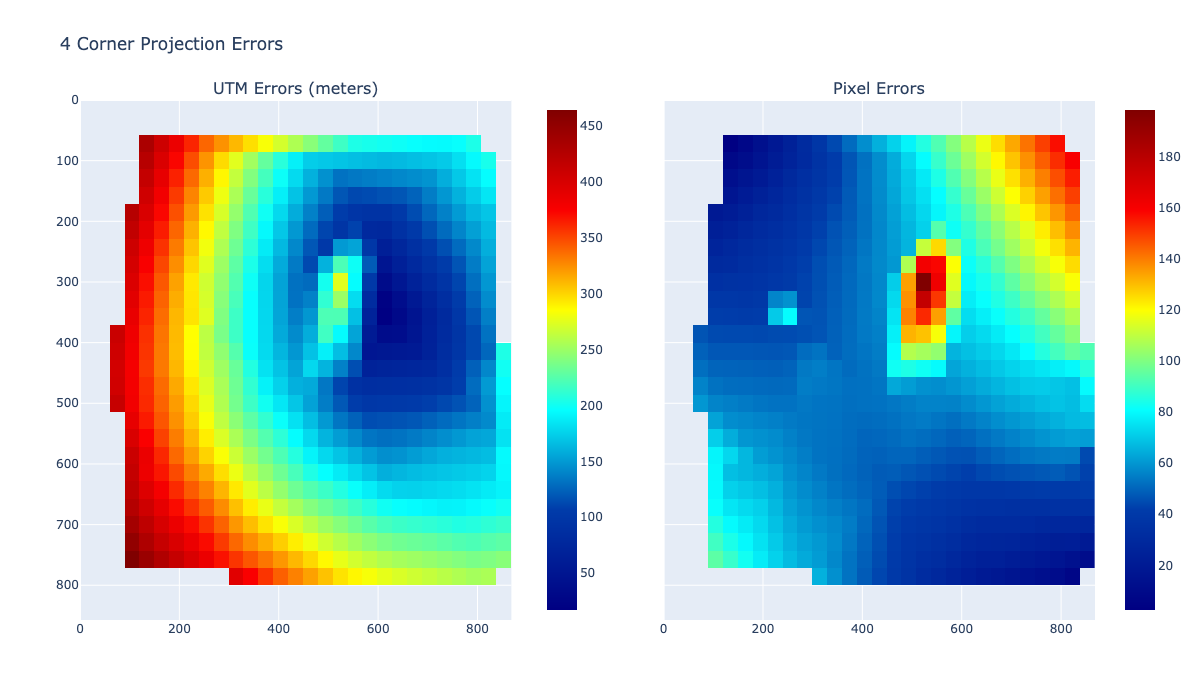

In [19]:
fig2 = sp.make_subplots( rows = 1, cols = 2,
                         horizontal_spacing = 0.15,
                         shared_xaxes = True,
                         shared_yaxes = True,
                         subplot_titles = ['UTM Errors (meters)', 'Pixel Errors' ] )

fig2.add_trace( go.Heatmap( z = utm_grid_vals,
                            x = np.linspace( 0, int(image_size[0]), numPixels ),
                            y = np.linspace( 0, int(image_size[1]), numPixels ),
                            colorbar_x=0.45, colorscale = 'Jet',
                            name = 'UTM Project Errors (meters)' ),
                row = 1, col = 1 )

fig2.add_trace( go.Heatmap( z = pix_grid_vals,
                            x = np.linspace( 0, int(image_size[0]), numPixels ),
                            y = np.linspace( 0, int(image_size[1]), numPixels ),
                            colorscale = 'Jet',
                            name = 'Pixel Project Errors (Pixels)' ),
                row = 1, col = 2 )

fig2.update_layout( width = 1200, height = 700, title = '4 Corner Projection Errors' )
fig2.update_layout(yaxis=dict(autorange='reversed'))
fig2.write_image( 'docs/usgs-4-corner-diffs.png' )
fig2.show( renderer = 'png' )

## Geo-Transform Comparison



### Solving GeoTransforms

Given a System of Linear Equations where

$$
A = 
$$




In [20]:
#  Create model from GCPs
geo_model = SENSRB.solve( gcps       = lla_gcp_list,
                          image_size = image_size )

errors = compute_errors( geo_model, flat_dem, lla_gcp_list )

UTM RMS Error: 4.08 meters
Mean Error: 16.63 meters
PIX RMS Error: 3.49 pixels
Mean Error: 12.19 pixels


In [21]:
img_path_out = 'USGS-Arial.geo.tif'

gxform = geo_model.get_transform_array()

gdal_cmd = f'gdal_translate -a_gt {gxform[4]} {gxform[0]} {gxform[1]} {gxform[5]} {gxform[2]} {gxform[3]} {img_path} {img_path_out}' 
print(gdal_cmd)

gdal_translate -a_gt -104.9747644598369 1.5914260062418334e-05 -1.7570929319019914e-07 39.769252949265976 -1.6111756767308617e-07 -1.2294859593866181e-05 ARUDEN000040045.2.tif USGS-Arial.geo.tif


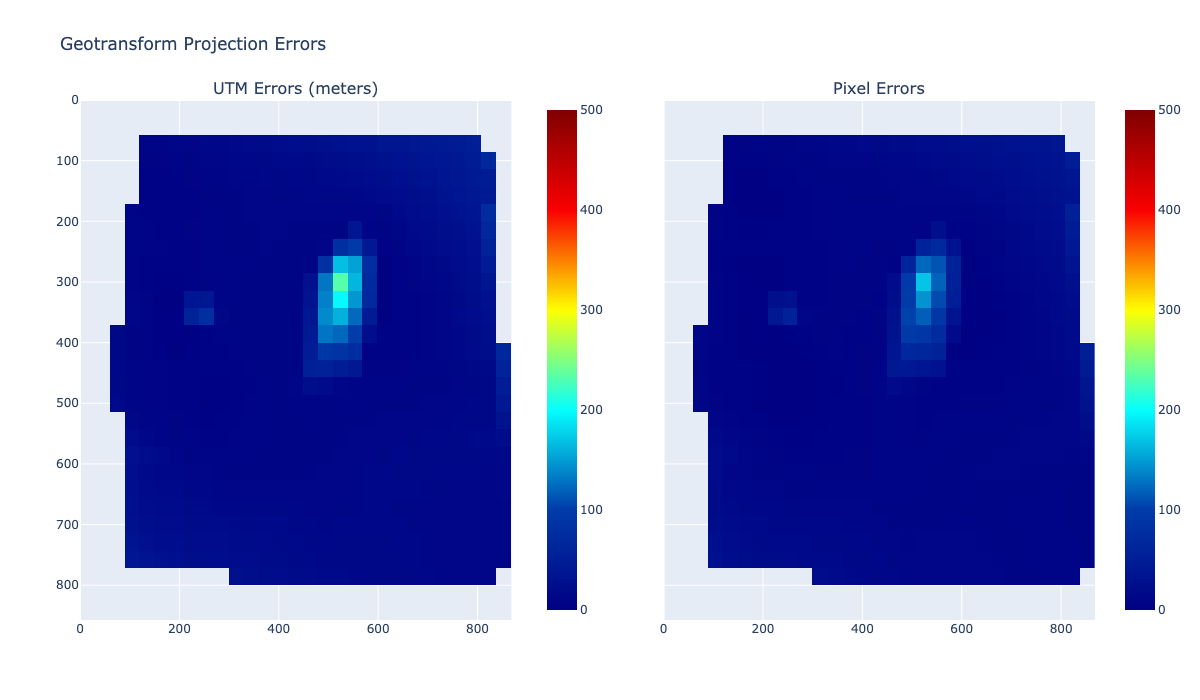

In [22]:
fig3 = sp.make_subplots( rows = 1, cols = 2,
                         horizontal_spacing = 0.15,
                         shared_xaxes = True,
                         shared_yaxes = True,
                         subplot_titles = ['UTM Errors (meters)', 'Pixel Errors' ] )

fig3.add_trace( go.Heatmap( z = errors.utm_grid_vals,
                            x = np.linspace( 0, int(image_size[0]), numPixels ),
                            y = np.linspace( 0, int(image_size[1]), numPixels ),
                            colorbar_x=0.45, colorscale = 'Jet',
                            zmin = 0, zmax = 500,
                            name = 'UTM Project Errors (meters)' ),
                row = 1, col = 1 )

fig3.add_trace( go.Heatmap( z = errors.pix_grid_vals,
                            x = np.linspace( 0, int(image_size[0]), numPixels ),
                            y = np.linspace( 0, int(image_size[1]), numPixels ),
                            colorscale = 'Jet',
                            zmin = 0, zmax = 500,
                            name = 'Pixel Project Errors (Pixels)' ),
                row = 1, col = 2 )

fig3.update_layout( width = 1200, height = 700, title = 'Geotransform Projection Errors' )
fig3.update_layout(yaxis=dict(autorange='reversed'))
fig3.write_image( 'docs/usgs-geotransform-diffs.png' )
fig3.show( renderer = 'png' )

## Computing Rational Polynomial Coefficients

We use RPCs first, so we can more easily solve the other models. 


In [23]:
#  Create model from GCPs
rpc_model = RPC00B.solve( gcps       = lla_gcp_list,
                          dem        = flat_dem,
                          image_size = image_size,
                          solver     = Solve_Method.WEIGHTED_LEAST_SQUARES,
                          rpc_type   = RPC_Type.B )

In [24]:
rpc_errors = compute_errors( rpc_model, flat_dem, lla_gcp_list, p2w = False )

PIX RMS Error: 130.16 pixels
Mean Error: 16942.17 pixels


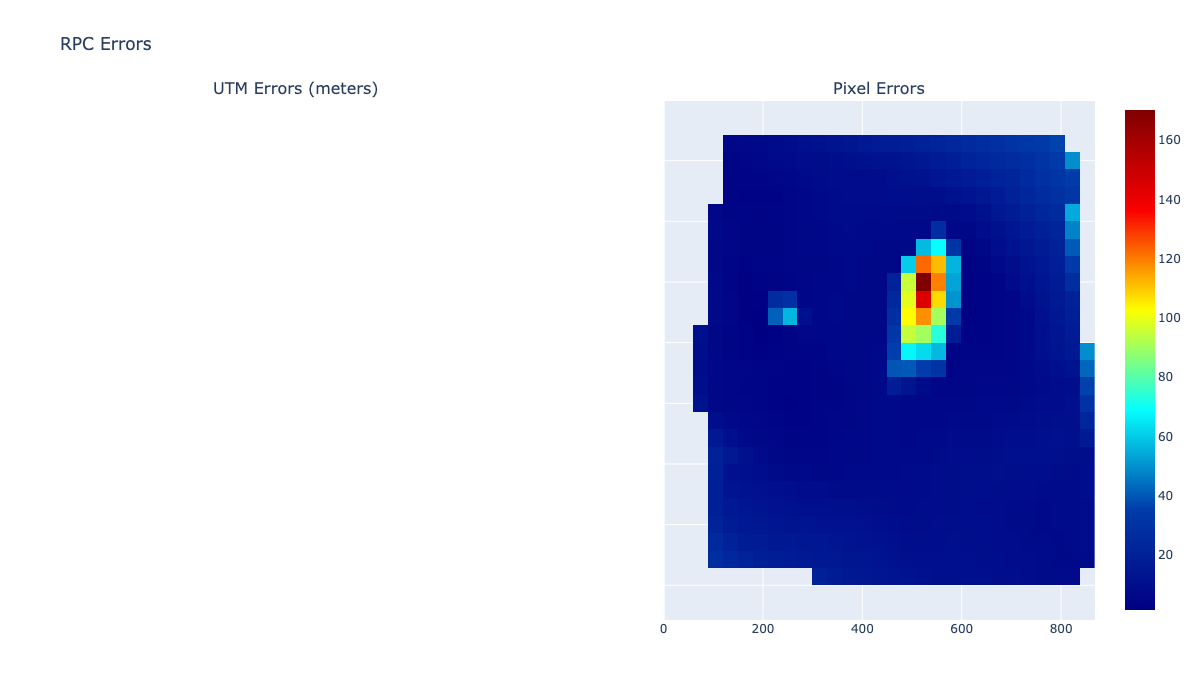

In [25]:
fig4 = sp.make_subplots( rows = 1, cols = 2,
                         horizontal_spacing = 0.15,
                         shared_xaxes = True,
                         shared_yaxes = True,
                         subplot_titles = ['UTM Errors (meters)', 'Pixel Errors' ] )

fig4.add_trace( go.Heatmap( z = errors.pix_grid_vals,
                            x = np.linspace( 0, int(image_size[0]), numPixels ),
                            y = np.linspace( 0, int(image_size[1]), numPixels ),
                            colorscale = 'Jet',
                            name = 'Pixel Project Errors (Pixels)' ),
                row = 1, col = 2 )

fig4.update_layout( width = 1200, height = 700, title = 'RPC Errors' )
fig4.update_layout(yaxis=dict(autorange='reversed'))
fig4.write_image( 'docs/usgs-rpc-errors.png' )
fig4.show( renderer = 'png' )

Verification Method

In [26]:
tl_pix = np.array( [ 0, 0 ], dtype = np.float64 )
tr_pix = np.array( [image_size[0] - 1, 0], dtype = np.float64 )
bl_pix = np.array( [0, image_size[1] - 1], dtype = np.float64 )
br_pix = image_size - np.array([1,1])

In [27]:
points = []

pix_deltas = []
utm_deltas = []

pix_sum = 0
utm_sum = 0

for gcp in gcps:

    #  Convert GCP LLA to UTM
    gcp_utm = crd_xform.transform( *gcp.coordinate )[0:2]

    #  Get the interpolation factors
    tx = gcp.pixel[0] / image_size[0]
    ty = gcp.pixel[1] / image_size[1]

    # Solve the UTM Coordinate
    utm_p1 = tl_utm[0:2] * (1-tx) + tr_utm[0:2] * tx
    utm_p2 = bl_utm[0:2] * (1-tx) + br_utm[0:2] * tx
    utm_pt = utm_p1 * (1-ty) + utm_p2 * ty

    #  Solve the pixel coordinate
    tx1 = ( gcp_utm[0] - tl_utm[0] ) / ( tr_utm[0] - tl_utm[0] )
    tx2 = ( gcp_utm[0] - bl_utm[0] ) / ( br_utm[0] - bl_utm[0] )
    ty = ( gcp_utm[1] - tl_utm[1] ) / ( br_utm[1] - tl_utm[1] )
    
    pix_p1 = tl_pix * (1-tx1) + tr_pix * tx1
    pix_p2 = bl_pix * (1-tx2) + br_pix * tx2
    
    pix_pt = pix_p1 * (1-ty) + pix_p2 * ty
    
    points.append( gcp.pixel )

    delta = pix_pt[0:2] - gcp.pixel
    pix_error = math.sqrt( np.dot( delta, delta ) )
    pix_deltas.append( pix_error )
    pix_sum += pix_error

    delta = utm_pt[0:2] - gcp_utm
    utm_error = math.sqrt( np.dot( delta, delta ) )
    utm_deltas.append( utm_error )
    utm_sum += utm_error
    

pix_mean_corners = pix_sum / len(gcps)
pix_rms_corners = math.sqrt( pix_mean_corners )

utm_mean_corners = utm_sum / len(gcps)
utm_rms_corners = math.sqrt( utm_mean_corners )

numPixels = 100

print( f'UTM RMS Error: {utm_rms_corners:.02f} meters\nMean Error: {utm_mean_corners:.02f} meters' )
print( f'Pix RMS Error: {pix_rms_corners:.02f} pixels\nMean Error: {pix_mean_corners:.02f} pixels' )

grid_x, grid_y = np.mgrid[ 0:int(image_size[0]):numPixels, 0:int(image_size[1]):numPixels ]

print( f'grid_x: {grid_x.shape}, grid_y: {grid_y.shape}' )
utm_grid_vals = scipy.interpolate.griddata( points, utm_deltas, (grid_x, grid_y), method='linear' )
pix_grid_vals = scipy.interpolate.griddata( points, pix_deltas, (grid_x, grid_y), method='linear' )

print( 'Pix Grid Vals: ', pix_grid_vals.shape)

NameError: name 'gcps' is not defined